The goal this time is to make things more realistic using curved tracks.

Author: Dustin Anderson

In [1]:
# Standard imports
import sys

# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers

# Local imports 
sys.path.append("/home/duanders/AI-HEP.Trk/discrete_extraps")
from drawing import draw_event, draw_input_and_pred

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


Let's make a new toy detector that looks like a cross section of CMS.  Tracks will be arcs of circles, originating at the center and extending outwards.

In [2]:
# training parameters
batch_size=256
epoch_size = 256000

# problem definition
mean_tracks = 10
det_size = 200
min_p = 0.1
max_p = 1
p_mean = (max_p+min_p)/2
p_sdev = (max_p-min_p)/np.sqrt(12)
phi_mean = np.pi
phi_sdev = 2*np.pi/np.sqrt(12)

def simulate_curved_track(p_reg, phi_reg, q, det_size=det_size):
    """
    Parameters:
        p_reg: track momentum (regularized to mean 0, stddev 1)
        phi_reg: track angle (regularized to mean 0, stddev 1)
        q: track charge (+/- 1)
        det_size: linear size of detector cross-section
    Returns:
        ndarray of binary detector data for one track.
    """
    p = p_reg*p_sdev + p_mean
    phi = phi_reg*phi_sdev + phi_mean
    
    event = np.zeros((det_size, det_size))
    scaled_p = p*2*np.sqrt(2)/det_size
    radius = 1/scaled_p
    phi_offset = np.pi/2 * np.sign(q)
    t = np.arange(0, np.pi, scaled_p)
    x = (radius*( np.cos(phi+phi_offset) + np.cos(np.pi/2+phi-t) ) + det_size/2.0).astype(int)
    y = (radius*( np.sin(phi+phi_offset) + np.sin(np.pi/2+phi-t) ) + det_size/2.0).astype(int)
    points = [ point for point in zip(x,y) 
                         if point[0] >= 0 and point[0] < det_size and point[1] >= 0 and point[1] < det_size ]
    for point in points:
        event[point[0],point[1]] = 1
    return event

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_size=det_size):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # momentum, charge, and angle are randomized
        ps = (np.random.random_sample(size=batch_size)-0.5)*np.sqrt(12)
        phis = (np.random.random_sample(size=batch_size)-0.5)*np.sqrt(12)
        #qs = np.random.randint(2, size=batch_size)*2-1
        qs = np.ones((batch_size))
        tracks = np.zeros((batch_size, 1, det_size, det_size))
        targets = zip(ps, phis, qs)
        for i, (p, phi, q) in enumerate(targets):
            tracks[i,0] = simulate_curved_track(p, phi, q, det_size)
        targets = np.asarray(targets)
        targets = targets[:,:2] ## TODO: accomodate charge
        yield tracks, targets
        
# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_n_tracks(batch_size=batch_size, det_size=det_size, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_size=det_size)
    while True:
        batch_events = np.zeros((batch_size, 1, det_size, det_size))
        batch_targets = -np.ones((batch_size, n_tracks, 2))
        for n in range(batch_size):
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)
            batch_targets[n] = event_targets[event_targets[:,1].argsort()] # sort by second column
        yield batch_events, batch_targets

For now all the tracks have the same charge.  It should be easy for the model to discriminate between the two charge values, but adding charge (a categorical variable) to the output of the model is a technical complication that I still need to deal with.

## Model 8: curved track finder \#1

I will be ambitious and see if the existing model can be used on events with 10 curved tracks.  

In [9]:
# Model
def build_model_8():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_size, det_size))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(mean_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [11]:
# Train the model
model_8 = build_model_8()
train_generator = gen_n_tracks()
%time model_8.fit_generator(train_generator, epoch_size, 4)

INFO (theano.gof.compilelock): Refreshing lock /home/duanders/.theano/compiledir_Linux-3.19--generic-x86_64-with-Ubuntu-15.04-vivid-x86_64-2.7.9-64/lock_dir/lock


Epoch 1/4
51200/51200 [==============================] - 213s - loss: 0.5971   
Epoch 2/4
51200/51200 [==============================] - 213s - loss: 0.3685   
Epoch 3/4
51200/51200 [==============================] - 212s - loss: 0.2855   
Epoch 4/4
51200/51200 [==============================] - 213s - loss: 0.2211   
CPU times: user 14min 48s, sys: 6min 33s, total: 21min 21s
Wall time: 14min 25s


[[ 1.24763115 -1.59943578]
 [ 1.61551689 -1.22481609]
 [-0.01081636 -0.5236363 ]
 [-1.59728063  0.43655805]
 [ 1.42255996  0.5811041 ]
 [ 0.75922465  0.82213732]
 [-1.6593206   1.02692713]
 [-0.05429235  1.26953953]
 [ 0.22819617  1.63861068]
 [ 1.26601456  1.71432574]]
[[ 1.04242074 -1.60223067]
 [ 1.72613013 -1.37352479]
 [ 0.33139667 -0.60696006]
 [-0.43939778  0.30455604]
 [ 0.13817742  0.71028793]
 [ 0.32346767  0.85842705]
 [-0.95416415  1.00126231]
 [-0.16263668  1.28211677]
 [ 0.71691781  1.51450193]
 [ 1.06366956  1.6291002 ]]


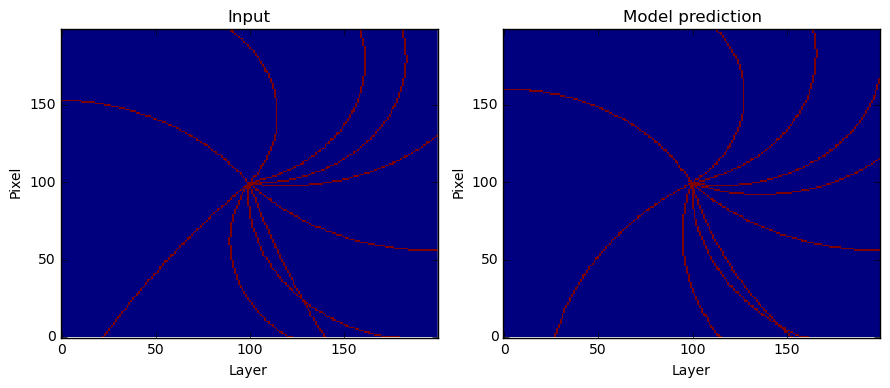

In [17]:
# Visualize prediction
test_data = gen_n_tracks().next()
test_event = test_data[0][0]
test_target = test_data[1][0]
test_pred = model_8.predict(np.asarray([test_event]))[0]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_curved_track(line[0], line[1], 1, det_size) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

It actually performs decently.  I bet that by tweaking the model we can arrive at something that works well.

## Model 9: more layers and convolutional filters

In [3]:
# Model
def build_model_9():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_size, det_size))
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(48, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(48, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(128, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(128, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(800)(layer)
    layer = layers.RepeatVector(mean_tracks)(layer)
    layer = layers.LSTM(800, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [4]:
# Train the model
model_9 = build_model_9()
train_generator = gen_n_tracks()
%time model_9.fit_generator(train_generator, epoch_size, 6)

Epoch 1/6
256000/256000 [==============================] - 1224s - loss: 0.9954  
Epoch 2/6
256000/256000 [==============================] - 1219s - loss: 0.8749  
Epoch 3/6
256000/256000 [==============================] - 1221s - loss: 0.8571  
Epoch 4/6
256000/256000 [==============================] - 1222s - loss: 0.8560  
Epoch 5/6
256000/256000 [==============================] - 1222s - loss: 0.8560  
Epoch 6/6
256000/256000 [==============================] - 1223s - loss: 0.8563  
CPU times: user 2h 11min 24s, sys: 1h 41min 9s, total: 3h 52min 33s
Wall time: 2h 2min 23s


[[-1.27494033 -1.45115899]
 [-1.06779504 -1.17784507]
 [ 0.34523952 -0.8909439 ]
 [ 0.99729491 -0.51429942]
 [-0.57845204 -0.10399623]
 [-1.08943355  0.14758912]
 [ 0.33654627  0.34536175]
 [ 0.22055973  0.72637402]
 [ 1.72974828  0.79642637]
 [-1.11974515  1.24776988]]
[[ 0.04179383 -1.64983654]
 [ 0.04595159 -0.12413749]
 [ 0.04658887  0.1097082 ]
 [ 0.04667671  0.14192478]
 [ 0.04668849  0.14629523]
 [ 0.04669013  0.14688675]
 [ 0.04669045  0.14696662]
 [ 0.04669038  0.14697765]
 [ 0.04669049  0.14697908]
 [ 0.04669033  0.14697944]]


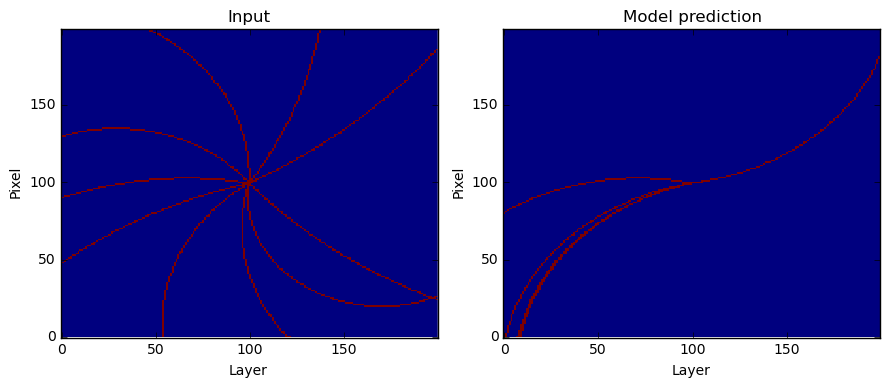

In [5]:
# Visualize prediction
test_data = gen_n_tracks().next()
test_event = test_data[0][0]
test_target = test_data[1][0]
test_pred = model_9.predict(np.asarray([test_event]))[0]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_curved_track(line[0], line[1], 1, det_size) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

In [6]:
model_9.save("model_9.h5")

Ideas: I increased the depth of the network and the training slowed down.  I might investigate if batch normalization helps it train faster and/or reach a better minimum.